In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import KFold

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv.gz', compression='gzip')
train = train.drop(train[train.price.isnull()].index)

test = pd.read_csv('data/test.csv.gz', compression='gzip')

subm = pd.read_csv('data/sample_submission.csv.gz', compression='gzip')

In [3]:
# Объединим трейн и тест

test['price'] = -1

data = pd.concat([train, test], 0) #, sort=False)
data.reset_index(drop=True, inplace=True)

In [4]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred) / (y_true)).replace([-np.inf, np.inf], np.nan).dropna())*100

def cv_mode(CV):
    
    if CV:
    
        cv = KFold(n_splits=5, shuffle=False, random_state=42).split(data.iloc[:train.shape[0]])
    
    else:
        i_tr = data.iloc[:train.shape[0]].index
        i_tst = data.iloc[train.shape[0]:].index
        cv = (i_tr, i_tst)
    
    return cv

def make_prediction( model, X, y, i_tr, i_tst):
    X_train, X_test = X.iloc[i_tr, :], X.iloc[i_tst, :]
    y_train, y_test = np.log1p(y.iloc[i_tr]), y.iloc[i_tst]
    model.fit(X_train, y_train)
    prediction = np.expm1(model.predict(X_test))
    return prediction, MAPE(y_test, prediction)
        
    
def cross_val(model, X, y, CV=True):
    cv = cv_mode(CV)
    scores = []
    for i_tr, i_tst in cv:
        _, score = make_prediction(model, X, y, i_tr, i_tst)
        scores.append(score)
    return np.mean(scores), np.std(scores)


def make_subm(model, X, y, filename, CV=False):
    cv = cv_mode(CV)
    (i_tr, i_tst) = cv
    prediction, _ = make_prediction(model, X, y, i_tr, i_tst)
    subm['price'] = prediction
    subm.to_csv(filename, index=False)
    pass



# KNN 

In [5]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Посчитаем количество количество соседей в некотором радиусе для каждой квартиры
# Как думаете считать будем только по трейну или объединим трейн и тест? 

In [6]:
nb = NearestNeighbors(radius=1.0, n_jobs=-1)

In [7]:
for r in [0.001, 0.01]:
    nb = NearestNeighbors(radius=r, n_jobs=-1)
    nb.fit(data[['latitude', 'longitude']])
    nbrs = nb.radius_neighbors(data[['latitude', 'longitude']], r, return_distance=False)
    data['nn_' + str(r)] = [len(x) for x in nbrs]
    

In [8]:
# чем эти признаки сейчас отличается для трейна и теста? 

In [ ]:
# Теперь посчитаем статиcтики по ценам соседних квартир. 
# Здесь учимся только на трейне
# Сразу думаем чем отличается признак для трейна и для теста

In [9]:
def get_nn_fe(i, nb):
    return_list = []
    
    for r in [0.001, 0.01]:
        
        nbrs = nb.radius_neighbors([[data.loc[i, 'latitude'], data.loc[i, 'longitude']]], r, 
                                      return_distance=False)
        ys = train.price[nbrs[0][nbrs[0] != i]]
        
        return_list.append(ys.mean())
        return_list.append(ys.max())
        return_list.append(ys.min())
        return_list.append(ys.std())
        
    
    return return_list

In [10]:
from tqdm import tqdm

In [11]:
nb=NearestNeighbors(radius=0.01, n_jobs=-1)
nb.fit(train[['latitude', 'longitude']])

knn_fe = []
for i in tqdm(range(data.shape[0])):
    knn_fe.append(get_nn_fe(i, nb))
knn_fe = np.vstack(knn_fe)

100%|██████████| 74815/74815 [06:44<00:00, 185.06it/s]


In [12]:
# Назовем колонки так, чтобы было понятно что это такое

from itertools import product

cols = ['price_' + str(x)+ '_' + str(y) for x, y in product([0.001, 0.01], ['mean', 'max', 'min', 'std'])]
                          
knn_fe = pd.DataFrame(index = data.index, data = knn_fe, columns = cols)

In [ ]:
# Посмотрим как повлияли на качество новые признаки

In [13]:
num_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
            'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
            'minimum_nights', 'latitude', 'longitude']

X = data[num_cols].fillna(0)
y = data.price

In [14]:
# Функция feature importance

def print_fi(model, X):
    fi = pd.Series(index=X.columns, data=model.feature_importances_).sort_values(ascending=False)
    sns.barplot(y=fi.index, x=fi);
    pass

In [15]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()

In [16]:
cross_val(model, X, y, CV=True)

(31.114155865397503, 1.5548731381178753)

In [ ]:
# важность признаков мы смотрим для последнего фолда

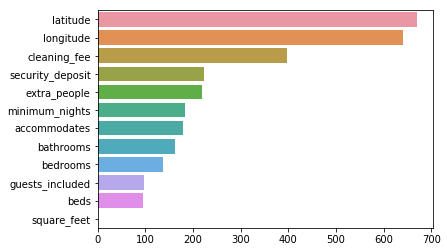

In [17]:
print_fi(model, X)

In [18]:
X = X.join(data[['nn_0.001', 'nn_0.01']]).join(knn_fe) 

In [ ]:
# В кросс-валидации у нас только трейн.  Те и в трейне и в валидации объекты на которых мы учились
# для knn признаков. Подумайте здесь так можно делать? А когда так нельзя делать? 

In [19]:
cross_val(model, X, y, CV=True)

(30.748870377981156, 1.5073547404242225)

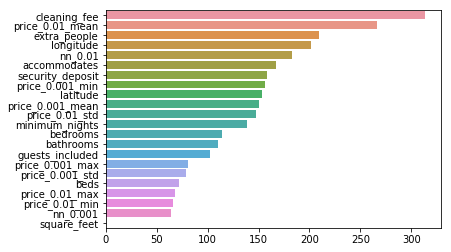

In [20]:
print_fi(model, X)

## Используем дополнительные таблицы

In [ ]:
# Календарь

In [23]:
cldr = pd.read_csv('data/calendar.csv.gz', compression='gzip')

In [24]:
cldr.head()

,listing_id,date,available
0,9554,2019-08-18,t
1,97446,2019-11-04,f
2,97446,2019-11-03,f
3,97446,2019-11-02,f
4,97446,2019-11-01,f


In [25]:
cldr.available = (cldr.available == 'f').astype(int)

In [ ]:
#  Посчитаем статистику доступности жилья в следующем году

In [26]:
avlbl_rate = cldr.groupby('listing_id').apply(lambda x: x.available.sum() / x.shape[0])
avlbl_rate.name = 'avlbl_rate'

In [27]:
# добавим признак

data = data.merge(avlbl_rate.to_frame(), left_on='id', right_index=True, how='left')

In [ ]:
# Проверим как выросло качество относительно базового датасета

In [28]:
X = data[num_cols].fillna(0)
X['avlbl_rate'] = data['avlbl_rate']

In [29]:
cross_val(model, X, y, CV=True)

(30.495933165782553, 1.1970083975194161)

In [30]:
del cldr

In [ ]:
# Отзывы

In [32]:
reviews = pd.read_csv('data/reviews.csv.gz', compression='gzip')

In [33]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,9554,1184025,2012-04-26,1809049,Hana,"I stayed in London for a month to study, exp..."
1,9554,1206322,2012-04-30,2237488,Rishi,My bnb request was very last minute and i was ...
2,9554,1258541,2012-05-10,2150467,Panee,First time as airbnb!First time to London! I c...
3,9554,1405284,2012-06-03,1864672,Simone Cristina,A wonderful experience! The house is very well...
4,9554,1475969,2012-06-13,2438453,Sondra,We are so grateful that we trusted our intuiti...


In [34]:
reviews.comments[0]

'I  stayed  in London for a month to study, explore the city, and meet people along the way.  \r\n\r\nI think the area is a great place to set your base. The neighborhood is lively and friendly, with an eclectic mix of ethic restaurants, colorful grocery stores and a happening pub that stays open late. There’s a big, green park nearby which is great for running or having a coffee. Central London is twenty minutes away by Tube.\r\n\r\nThe apartment is charming, ceiling to floor. It actually does look even better than in the photos! The guest-room is bright and well heated, with a beautiful work desk and a spacious closet.  The kitchen is spacious and smells of fresh espresso in the morning. \r\n\r\nGuy is a friendly, reliable, easy- going host who knows (and loves!) London. Make sure to ask about the must-go London pubs and places to eat! \r\n\r\nAll in all, I’d wholeheartedly recommend the apartment and the neighborhood, not to mention the curry house down the street!  Enjoy !!! \r\n'

Обсуждаем что можно сделать c этой таблицей. считать количество отзывов, fasttext, предсказание тональности отзыва, идея что можно вытащить из них время до метро, искать слова обозначающие, проблемы, потому что отзывы, в основном, будут положительные. 

## Отбор признаков

In [35]:
X = X.join(data[['nn_0.001', 'nn_0.01']]).join(knn_fe) 

In [36]:
cross_val(model, X, y, CV=True)

(30.166526508719521, 1.2657689399434509)

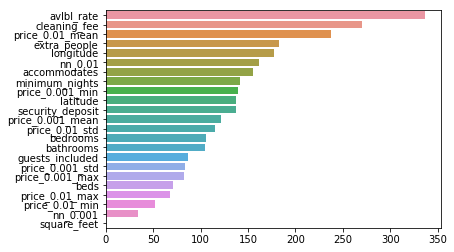

In [37]:
print_fi(model, X)

In [ ]:
# наверное топ 10 признаков самые важные и полезные? 

In [38]:
%%time
fi = pd.Series([])
for col in X.columns:
    fi[col] = cross_val(model, X.drop(col, axis=1), y, CV=True)

CPU times: user 7min 35s, sys: 4.98 s, total: 7min 40s
Wall time: 2min 41s


In [39]:
fi.sort_values()

price_0.01_std      (30.0692214837, 1.22291266648)
price_0.01_max       (30.0987933517, 1.2679172816)
nn_0.01              (30.104864439, 1.21642750402)
price_0.001_max     (30.1216044801, 1.26544890642)
latitude            (30.1358846526, 1.29650065464)
price_0.001_std      (30.138007546, 1.24051600348)
nn_0.001            (30.1407780018, 1.21025040634)
price_0.001_min     (30.1449738552, 1.27962314512)
price_0.01_min      (30.1520146976, 1.24935412283)
beds                 (30.162794315, 1.24602376139)
square_feet         (30.1665265087, 1.26576893994)
price_0.001_mean    (30.1926734068, 1.25935702131)
minimum_nights       (30.2360080705, 1.2791117369)
longitude           (30.2428310775, 1.25859373104)
price_0.01_mean     (30.3635920629, 1.27949337729)
bathrooms           (30.4524864926, 1.19557394731)
security_deposit     (30.481602416, 1.31099077317)
bedrooms            (30.4883612995, 1.27251649503)
guests_included     (30.5534834368, 1.25976820557)
avlbl_rate           (30.748870

In [47]:
cross_val(model, X.drop(fi.sort_values()[:4].index, axis=1), y, CV=True)

(30.10162567321343, 1.205596538754077)

In [ ]:
# один из удаленных признаков был из первой десятки важных для lgb признаков

In [ ]:
# отбор признаков перестановками

In [48]:
%%time

cv = cv_mode(CV=True)

fis=[]
for i_tr, i_tst in cv:
    X_train, X_test = X.iloc[i_tr, :], X.iloc[i_tst, :]
    y_train, y_test = np.log1p(y.iloc[i_tr]), y.iloc[i_tst]
    model.fit(X_train, y_train)
    prediction = np.expm1(model.predict(X_test))
    base_score = MAPE(y_test, prediction)
    fi = pd.Series([])
    for col in X_train.columns:
        tmp = X_test.copy()
        tmp[col] = np.random.permutation(tmp[col])
        prediction = np.expm1(model.predict(tmp))
        fi[col] = MAPE(y_test, prediction) - base_score
    fis.append(fi) 

CPU times: user 34.3 s, sys: 192 ms, total: 34.5 s
Wall time: 12.1 s


In [49]:
for fi in fis:
    print('---------')
    print(fi.sort_values()[:5])

---------
price_0.01_min    -0.016969
square_feet        0.000000
price_0.01_std     0.008689
price_0.01_max     0.069491
price_0.001_std    0.070954
dtype: float64
---------
price_0.01_min    -0.051010
square_feet        0.000000
price_0.001_std    0.002326
nn_0.001           0.050622
price_0.01_std     0.059035
dtype: float64
---------
price_0.001_std   -0.125720
price_0.01_std    -0.096351
price_0.01_max    -0.056105
latitude          -0.053507
square_feet        0.000000
dtype: float64
---------
price_0.01_std    -0.038006
price_0.01_min    -0.032925
price_0.001_std   -0.023435
price_0.001_max   -0.015633
nn_0.001          -0.002543
dtype: float64
---------
price_0.001_std   -0.057853
price_0.01_min    -0.009766
square_feet        0.000000
price_0.001_max    0.065046
price_0.01_std     0.068073
dtype: float64


In [ ]:
# теперь можно эти признаки пересекать, объединять, усреднять, устраивать голосование

In [50]:
# Пересекли

from functools import reduce
cols1 = reduce(np.intersect1d, ([fi.sort_values()[:5].index for fi in fis]))

cols1

array(['price_0.001_std', 'price_0.01_std'], dtype=object)

In [51]:
cross_val(model, X.drop(cols1, axis=1), y, CV=True)

(30.088652416645999, 1.2005260988603663)

In [52]:
# объединили

cols2 = reduce(np.union1d, ([fi.sort_values()[:5].index for fi in fis]))

cols2

array(['latitude', 'nn_0.001', 'price_0.001_max', 'price_0.001_std',
       'price_0.01_max', 'price_0.01_min', 'price_0.01_std', 'square_feet'], dtype=object)

In [53]:
cross_val(model, X.drop(cols2, axis=1), y, CV=True)

(30.121537906631346, 1.2432554602621193)